In [31]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial.distance import cdist

In [32]:
class GenerateData:
    def __init__(self,n_sample=500,n_features=30):
        self.n_sample = n_sample
        self.n_features = n_features

    def make_classification(self):
        """Generate some sample data"""
        x,y = make_classification(n_samples=self.n_sample, n_features=self.n_features,
                                   n_redundant=1, n_clusters_per_class=1,flip_y=0.001,random_state=42)
        y = 2 * y - 1
        return x,y                 

    def split_data(self,X, y, test_size=0.2):
        """Split the data into training and test sets."""
        n_test = int(self.n_sample * test_size)
        indices = np.random.permutation(self.n_sample)
        X_train = X[indices[:-n_test]]
        y_train = y[indices[:-n_test]]
        X_test = X[indices[-n_test:]]
        y_test = y[indices[-n_test:]]
        return X_train, X_test, y_train, y_test  

In [33]:
class KernelRidgeRegression: 
    def __init__(self,lambda_param=1.0):
        self.lambda_param = lambda_param
    def kernel(self, X, Z, kernel_type='linear', gamma=1e-3, degree=3):
        """Compute the kernel matrix"""
        if kernel_type == 'linear':
            return X @ Z.T
        elif kernel_type == 'rbf':
            return np.exp(-gamma * cdist(X, Z, 'sqeuclidean'))
        elif kernel_type == 'poly':
            return (X @ Z.T + 1)**degree
    def loss_function(self, X, y, alpha):
        """Calculate the training loss function value"""
        n = X.shape[0]
        K = self.kernel(X, X)
        residual = y - K @ alpha
        loss = (residual.T @ residual) / (2 * n) + (self.lambda_param / 2) * (alpha.T @ K @ alpha)
        return loss
    def predictions(self, X_train,X_test, alpha):
        """Make predictions"""
        return np.sign(self.kernel(X_test,X_train) @ alpha)
    def accuracy(self, X_train,X_test, y, alpha):
        """Calculate the accuracy"""
        return accuracy_score(y, self.predictions(X_train,X_test, alpha))
    def test_loss_function(self, X_train,X_test, y, alpha):
        """Calculate the test loss function value"""
        n= X_test.shape[0]
        loss = 1/(2*n) * np.linalg.norm(y-self.kernel(X_test,X_train)@alpha)**2
        return loss
    def gradient(self, X, y, alpha):
        """Calculate the gradient of the loss function"""
        n= X.shape[0]
        K = self.kernel(X,X)
        grad = K@((1/n * K + self.lambda_param * np.identity(n)) @ alpha - 1/n * y)
        #1/n * K @ (K@alpha - y) + self.lambda_param * K@alpha
        return grad
    def gradient_descent(self, X, y, alpha_init, learning_rate, max_iters, loss_target):
        alpha_values = []
        alpha = alpha_init
        i=0
        alpha_values.append(alpha)
        while self.loss_function(X, y, alpha) > loss_target and i < max_iters-1:
        #grad = self.gradient(X, y, alpha)
        #while np.linalg.norm(grad) > loss_target and i < max_iters-1:
            grad = self.gradient(X, y, alpha)
            alpha = alpha - learning_rate * grad
            i+=1
            alpha_values.append(alpha)
        #print(f'Number of iterations: {i}')
        return alpha,alpha_values
    
    def chebychev_root(self,L,mu,t,i):
        w = L+ mu + (L-mu)*np.cos((i+1/2)*np.pi/(t))
        return w/2
    def permutation(self,previous, T):
        change = [2 * T + 1 - p for p in previous]
        new= []
        for a in range(np.size(previous)):
            new.append(previous[a])
            new.append(change[a])
        return new
    def perm(self,T):
        perm= [1]
        i = 1
        while i < T:
            perm = self.permutation(perm, i)
            i *= 2
        return perm

    def fit_fractal_chebychev(self,X,y,alpha_init,max_iters,loss_target,fractal=False): 
        alpha_values = []
        alpha = alpha_init
        i=0
        alpha_values.append(alpha)
        L,mu = self.constante_L(X)
        
        roots = [self.chebychev_root(L, mu, max_iters-1, i) for i in range(max_iters)]
        permute = self.perm(max_iters-1)
        permuted_roots = [roots[i-1] for i in permute]
        
        while self.loss_function(X, y, alpha) > loss_target and i < max_iters-1:
        #grad = self.gradient(X, y, alpha)
        #while np.linalg.norm(grad) > loss_target and i < max_iters-1:
            grad = self.gradient(X, y, alpha)
            if fractal:
                alpha = alpha - 1/permuted_roots[i] * grad
            else :
                alpha = alpha - 1/roots[i] * grad
            i+=1
            alpha_values.append(alpha)
        #print(f'Number of iterations: {i}')
        return alpha,alpha_values

    def constante_L(self, X):
        """Compute the Lipschitz constant"""
        n= X.shape[0]
        K= self.kernel(X,X)
        eigenvals,_ = np.linalg.eigh(1/n * K.T@K + self.lambda_param * K)
        L = np.max(eigenvals)
        mu = np.min(eigenvals)
        return L,mu
    def alpha_opt(self, X, y):
        """Compute the optimal w for the training set"""
        n= X.shape[0]
        alpha = np.linalg.solve(self.kernel(X,X) + n *self.lambda_param * np.identity(n) , y)
        return alpha
    
    def compute_errors(self, X_train, X_test, y_train, y_test, alpha):
        """Compute training and test errors"""
        train_predictions = self.predictions(X_train,X_train, alpha)
        test_predictions = self.predictions(X_train,X_test, alpha)
        train_error = np.mean(np.sign(train_predictions) != y_train)
        test_error = np.mean(np.sign(test_predictions) != y_test)
        return train_error, test_error
    
    def plot_level_sets(self, X_train,X_test, y_train,y_test, w1,w2=None,w_3=None):
        """Plot level sets of the loss and the risk function"""
        alpha_range = np.linspace(-1, 1, 60) # value of first component of alpha
        beta_range = np.linspace(-1, 1, 60) # value of second component of alpha
        A, B = np.meshgrid(alpha_range, beta_range)
        Z_l = np.zeros_like(A)
        Z_r = np.zeros_like(A)
        alpha_opt = self.alpha_opt(X_train, y_train)
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                alpha_temp = alpha_opt.copy()
                alpha_temp[0] = A[i, j]
                alpha_temp[1] = B[i, j]
                Z_l[i, j] = self.loss_function(X_train, y_train, alpha_temp)
                Z_r[i, j] = self.test_loss_function(X_train,X_test, y_test, alpha_temp)  
    
        w_train = self.alpha_opt(X_train,y_train)
        
        min_risk_index = np.unravel_index(np.argmin(Z_r, axis=None), Z_r.shape)
        
        
        plt.figure()
        plt.contour(A, B, Z_l, levels=50, cmap='viridis', alpha=0.5)
        plt.contour(A, B, Z_r, levels=50, cmap='inferno', alpha=0.5, linestyles='dotted')

        plt.plot(np.array(w1)[:,0], np.array(w1)[:,1], color='black')
        plt.plot(np.array(w2)[:,0], np.array(w2)[:,1], color='green')
        if w_3 is not None:
            plt.plot(np.array(w_3)[:,0], np.array(w_3)[:,1], color='yellow')

        plt.scatter(w_train[0],w_train[1],color='red')
        plt.scatter(A[min_risk_index], B[min_risk_index], color='blue')
        # for alpha in Model_2.alpha_values[:Model_2.ite_max]:
        #     plt.scatter(alpha[0],alpha[1],color='green')  
        # for alpha in self.alpha_values[:self.ite_max]:
        #     plt.scatter(alpha[0],alpha[1],color='black') 
        # plt.scatter(alpha_train[0],alpha_train[1],color='red')

        plt.xlabel('Alpha 1')
        plt.ylabel('Alpha 2')
        plt.title('Level Sets of the Loss Function')
        legend_elements = [Line2D([0], [0], color='red', lw=2, label='Loss Function'),
                   Line2D([0], [0], color='blue', lw=2, label='Test loss Function'),
                   Line2D([0],[0],color='green', marker='o',linestyle='None',label='w2'),
                    Line2D([0],[0],color='black', marker='o',linestyle='None',label='w1'),
                    Line2D([0],[0],color='yellow', marker='o',linestyle='None',label=f'Chebyshev')]
        
        plt.legend(handles=legend_elements)
        plt.grid(True)
        #plt.savefig("Level_set.pdf")
        plt.show()


In [34]:
n_samples=50
n_features=3


Data= GenerateData(n_samples,n_features)
x,y = Data.make_classification()
 # Set the random seed for reproducibility
X_train, X_test, y_train, y_test = Data.split_data(x, y, test_size=0.2)

print("Training data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Training data shape:  (40, 3)
Test data shape:  (10, 3)


Lipschitz constant:  721.2866589246473
Mean Training accuracy:  0.7859999999999999
Mean Test accuracy:  0.7859999999999999
Mean Training loss:  0.34204220748248604
Mean Test loss:  0.3155897499750015
Mean Training accuracy fractal:  0.518
Mean Test accuracy fractal:  0.518
Mean Training loss fractal:  90879876.9596758
Mean Test loss fractal:  87726298.69161716


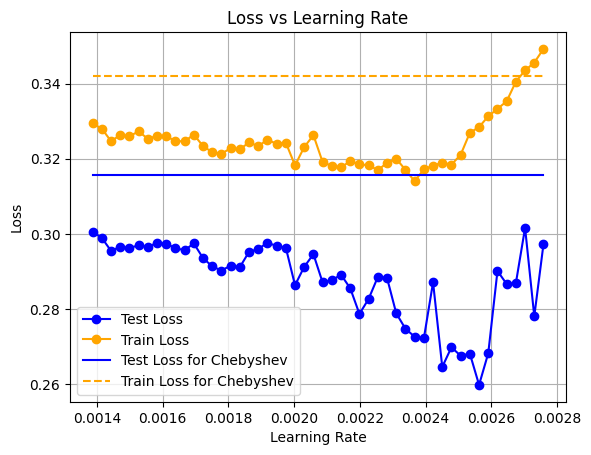

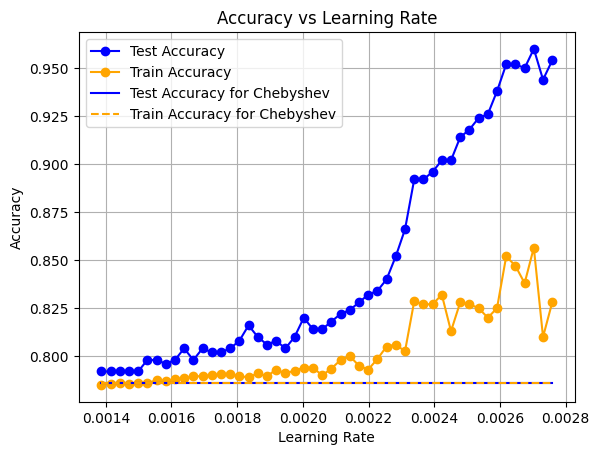

In [38]:
model = KernelRidgeRegression(lambda_param=0.0)
L,mu = model.constante_L(X_train)
print("Lipschitz constant: ", L)
initializations = [np.random.randn(X_train.shape[0]) for _ in range(50)]
learning_rate = 1/L
max_iters = 10000
loss_target = 0.4

train_accuracies = []
test_accuracies = []
train_loss = []
test_loss = []

train_accuracies_fractal = []
test_accuracies_fractal = []
train_loss_fractal = []
test_loss_fractal = []

for init in initializations:
    alpha_chebyshev, alpha_values = model.fit_fractal_chebychev(X_train, y_train, init, 32, loss_target)
    train_accuracies.append(model.accuracy(X_train, X_test, y_test, alpha_chebyshev))
    test_accuracies.append(model.accuracy(X_train, X_test, y_test, alpha_chebyshev))
    train_loss.append(model.loss_function(X_train, y_train, alpha_chebyshev))
    test_loss.append(model.test_loss_function(X_train, X_test, y_test, alpha_chebyshev))

    alpha_chebyshev_fractal, alpha_values_fractal = model.fit_fractal_chebychev(X_train, y_train, init, 32, loss_target, fractal=True)
    train_accuracies_fractal.append(model.accuracy(X_train, X_test, y_test, alpha_chebyshev_fractal))
    test_accuracies_fractal.append(model.accuracy(X_train, X_test, y_test, alpha_chebyshev_fractal))
    train_loss_fractal.append(model.loss_function(X_train, y_train, alpha_chebyshev_fractal))
    test_loss_fractal.append(model.test_loss_function(X_train, X_test, y_test, alpha_chebyshev_fractal))


mean_train_accuracy = np.mean(train_accuracies)
mean_test_accuracy = np.mean(test_accuracies)
mean_train_loss = np.mean(train_loss)
mean_test_loss = np.mean(test_loss)

print("Mean Training accuracy: ", mean_train_accuracy)
print("Mean Test accuracy: ", mean_test_accuracy)
print("Mean Training loss: ", mean_train_loss)
print("Mean Test loss: ", mean_test_loss)

mean_train_accuracy_fractal = np.mean(train_accuracies_fractal)
mean_test_accuracy_fractal = np.mean(test_accuracies_fractal)
mean_train_loss_fractal = np.mean(train_loss_fractal)
mean_test_loss_fractal = np.mean(test_loss_fractal)

print("Mean Training accuracy fractal: ", mean_train_accuracy_fractal)
print("Mean Test accuracy fractal: ", mean_test_accuracy_fractal)
print("Mean Training loss fractal: ", mean_train_loss_fractal)
print("Mean Test loss fractal: ", mean_test_loss_fractal)

loss_target = mean_train_loss+1e-2

learning_rates_s = np.linspace(1/L, 1.99/L, num=50)
accuracies = []
train_accuracies = []
test_loss = []
training_loss = []

for lr in learning_rates_s:
    acc_list = []
    train_acc_list = []
    test_loss_list = []
    train_loss_list = []
    for init in initializations:
        w, w_values = model.gradient_descent(X_train, y_train, init.copy(), lr, max_iters, loss_target)
        predictions = model.predictions(X_train, X_test, w)
        accuracy = model.accuracy(X_train, X_test, y_test, w)
        train_loss = model.loss_function(X_train, y_train, w)
        loss = model.test_loss_function(X_train, X_test, y_test, w)
        train_accuracy = model.accuracy(X_train, X_train, y_train, w)
        acc_list.append(accuracy)
        test_loss_list.append(loss)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)
    accuracies.append(np.mean(acc_list))
    test_loss.append(np.mean(test_loss_list))
    training_loss.append(np.mean(train_loss_list))
    train_accuracies.append(np.mean(train_acc_list))

plt.figure()
plt.plot(learning_rates_s, test_loss, marker='o', linestyle='-',label = 'Test Loss',color='blue')
plt.plot(learning_rates_s, training_loss, marker='o', linestyle='-', label='Train Loss',color='orange')
plt.plot(learning_rates_s, mean_test_loss*np.ones(50), linestyle='-', color='blue', label='Test Loss for Chebyshev')
plt.plot(learning_rates_s, mean_train_loss*np.ones(50), linestyle='--', color='orange', label='Train Loss for Chebyshev')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.grid(True)
#plt.savefig('Train_loss.pdf')
plt.show()

plt.figure()
plt.plot(learning_rates_s, accuracies, marker='o', linestyle='-', label='Test Accuracy',color='blue')
plt.plot(learning_rates_s, train_accuracies, marker='o', linestyle='-', label='Train Accuracy',color='orange')
plt.plot(learning_rates_s, mean_test_accuracy*np.ones(50), linestyle='-', color='blue', label='Test Accuracy for Chebyshev')
plt.plot(learning_rates_s, mean_train_accuracy*np.ones(50), linestyle='--', color='orange', label='Train Accuracy for Chebyshev')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.grid(True)
#plt.savefig('Accuracy.pdf')
plt.show()


In [36]:
""" print(" ")
print("LEARNING RATE: ", learning_rate)
w,w_values = model.gradient_descent(X_train, y_train, w_init.copy(), learning_rate, max_iters, loss_target)

loss_train = model.loss_function(X_train, y_train, w)
loss_test = model.test_loss_function(X_train,X_test, y_test, w)
print("Training loss: ", loss_train)
print("Test loss: ", loss_test)

train_error,test_error = model.compute_errors(X_train, X_test, y_train, y_test, w)
print("Training error: ", train_error)
print("Test error: ", test_error)


learning_rate =1.8/L
print(" ")
print("LEARNING RATE: ", learning_rate)
w2,w2_values = model.gradient_descent(X_train, y_train, w_init.copy(), learning_rate, max_iters, loss_target)

loss_train = model.loss_function(X_train, y_train, w2)
loss_test = model.test_loss_function(X_train,X_test, y_test, w2)
print("Training loss: ", loss_train)
print("Test loss: ", loss_test)

train_error,test_error = model.compute_errors(X_train, X_test, y_train, y_test, w2)
print("Training error: ", train_error)
print("Test error: ", test_error) """

# print(" ")
# print("Chebyshev: ")
# w3,w3_values = model.Chebyshev(X_train, y_train, w_init.copy(), max_iters, loss_target)
# print("Optimal weights: ", w3)

# loss_train = model.loss_function(X_train, y_train, w3)
# loss_test = model.test_loss_function(X_train,X_test, y_test, w3)
# print("Training loss: ", loss_train)
# print("Test loss: ", loss_test)

# train_error,test_error = model.compute_errors(X_train, X_test, y_train, y_test, w3)
# print("Training error: ", train_error)
# print("Test error: ", test_error) 

#model.plot_level_sets(X_train,X_test, y_train,y_test,w_values,w2_values)

' print(" ")\nprint("LEARNING RATE: ", learning_rate)\nw,w_values = model.gradient_descent(X_train, y_train, w_init.copy(), learning_rate, max_iters, loss_target)\n\nloss_train = model.loss_function(X_train, y_train, w)\nloss_test = model.test_loss_function(X_train,X_test, y_test, w)\nprint("Training loss: ", loss_train)\nprint("Test loss: ", loss_test)\n\ntrain_error,test_error = model.compute_errors(X_train, X_test, y_train, y_test, w)\nprint("Training error: ", train_error)\nprint("Test error: ", test_error)\n\n\nlearning_rate =1.8/L\nprint(" ")\nprint("LEARNING RATE: ", learning_rate)\nw2,w2_values = model.gradient_descent(X_train, y_train, w_init.copy(), learning_rate, max_iters, loss_target)\n\nloss_train = model.loss_function(X_train, y_train, w2)\nloss_test = model.test_loss_function(X_train,X_test, y_test, w2)\nprint("Training loss: ", loss_train)\nprint("Test loss: ", loss_test)\n\ntrain_error,test_error = model.compute_errors(X_train, X_test, y_train, y_test, w2)\nprint("Tra